This example computes the annual cycle for daily SST data in the NINO 3.4 region using the first two harmonics. It then computes the SST anomalies using the smoothed annual cycle and then plots a rolling average of the anomalies. 

Import Python Libraries

In [1]:
import os
import numpy as np
import numpy.ma as ma
from glob import glob
from time import strptime
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import Image, display

import scipy.io as sio
import xarray as xr

import matplotlib.dates as mdates

1.	Read the daily SST data from 1 Jan 1979- 31 Dec 2017 – for all tasks below use SST in C

In [2]:
filename_pattern  = '/home/voyager-sbarc/arc/reanalysis/erai/sfc/erai.sst.*'
erai_files = glob(filename_pattern) # search files 
erai_files.sort()

for ifile, file, in enumerate(erai_files):
    file_object = sio.readsav(file, python_dict=False,verbose=False)
    lons = file_object['rlon']
    lats = file_object['rlat']
    values0 = file_object['erai_sst']-273.15 ## convert to celsius
    
    if ifile == 0:
        values = values0
    else:
        values = ma.concatenate((values, values0))

In [5]:
## create array of times - daily between Jan 1, 1979 and Dec 31, 2017
times = pd.date_range('1979-01-01-00', '2017-12-31-18', freq='D', normalize=True)
times

DatetimeIndex(['1979-01-01', '1979-01-02', '1979-01-03', '1979-01-04',
               '1979-01-05', '1979-01-06', '1979-01-07', '1979-01-08',
               '1979-01-09', '1979-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=14245, freq='D')

In [6]:
## Read all data into single xarray dataset 
## this makes it easier to index bounds and do climatology stuff
ds = xr.Dataset({'sst': (['time', 'lat', 'lon'], values)},
                coords={'time': times,
                        'lat': (['lat'], lats),
                        'lon': (['lon'], lons)})
ds

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
  * lat      (lat) >f4 -89.46282 -88.76695 -88.06697 ... 88.76695 89.46282
  * lon      (lon) >f4 0.0 0.703 1.406 2.109 ... 357.124 357.827 358.53 359.233
Data variables:
    sst      (time, lat, lon) float32 9725.85 9725.85 ... -1.6902161 -1.6902161

Compute the daily mean SST in the NINO34 region; your time series will run from 1 Jan 1979 to 31 Dec 2017; each value is the mean SST in the NINO34 region

In [7]:
## Average area of NINO 3.4 region
##  region 5°N-5°S, 120°- 170°W
NINO34 = ds.sel(lat=slice(-5,5), lon=slice(360-170, 360-120))
NINO34 = NINO34.mean(('lat', 'lon'))
NINO34

<xarray.Dataset>
Dimensions:  (time: 14245)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2017-12-31
Data variables:
    sst      (time) float32 26.604568 26.600039 26.595533 ... 25.732569 25.74347

#### Plot Area-Average NINO3.4 

Text(0.5, 1.0, 'NINO 3.4 SST (*C)')

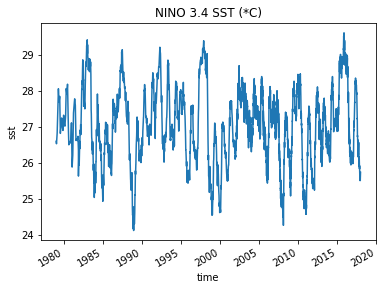

In [8]:
NINO34.sst.plot()
plt.title('NINO 3.4 SST (*C)')

Compute the daily climatological SST: your time series will have 365 values; first value is 1 January, which is the average of all 1 January values from 1979-2017, second value is 2 January, which is the average of all 2 January values from 1979-2017 etc.

In [9]:
climatology = NINO34.groupby('time.dayofyear').mean('time')
climatology

<xarray.Dataset>
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sst        (dayofyear) float32 26.521616 26.515951 ... 26.511227 25.910412

Create 1st two harmonics and add together

In [10]:
def calc_harmonics(tseries):
    ''' calculates sum of first two harmonics to approximate annual cycle'''
    mtot = tseries.size
    a0 = tseries.mean().item() # calculate mean of series
    t = np.arange(0, mtot, 1, dtype='float')

    omegas = []
    coef_a = []
    coef_b = []
    
    # compute coefficients
    for p in np.arange(1, 4):
        omegas.append((2.*np.pi*np.float(p))/np.float(mtot))
        coef_a.append((2./mtot)*(tseries*np.cos((2*np.pi*p*t)/mtot)).sum())
        coef_b.append((2./mtot)*(tseries*np.sin((2*np.pi*p*t)/mtot)).sum())
        
    ## first harmonic
    tsrecSC1 = a0 + coef_a[0].item()*np.cos(omegas[0]*t) + coef_b[0].item()*np.sin(omegas[0]*t)
    ## second harmonic
    tsrecSC2 = a0 + coef_a[1].item()*np.cos(omegas[1]*t) + coef_b[1].item()*np.sin(omegas[1]*t)
    ## first plus second harmonic
    tsrecSC = a0 + coef_a[0].item()*np.cos(omegas[0]*t) + coef_b[0].item()*np.sin(omegas[0]*t) + coef_a[1].item()*np.cos(omegas[1]*t) 
    
    return(tsrecSC1, tsrecSC2, tsrecSC)        

In [11]:
tsrecSC1, tsrecSC2, tsrecSC = calc_harmonics(climatology.sst)

2.	Make a plot with:
 -   a.	The daily climatological SST
 -  b.	Over-plot a time series given by the sum of the mean plus the annual harmonic
 -  c.	Over-plot a time series given by the sum of the mean plus the semi-annual harmonic
 -  d.	Over-plot a time series given by the sum of the mean, annual and semi-annual harmonics


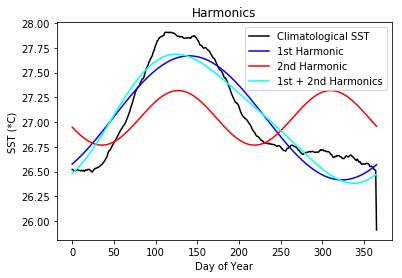

In [12]:
plt.plot(np.arange(climatology.sst.size), climatology.sst, 'k', label='Climatological SST')
plt.plot(np.arange(tsrecSC1.size), tsrecSC1, 'blue', label='1st Harmonic')
plt.plot(np.arange(tsrecSC2.size), tsrecSC2, 'red', label='2nd Harmonic')
plt.plot(np.arange(tsrecSC.size), tsrecSC, 'cyan', label='1st + 2nd Harmonics')
plt.title('Harmonics')
plt.ylabel('SST (*C)')
plt.xlabel('Day of Year')
plt.legend()
plt.show()

3.	Your SST annual cycle is given by the sum of the mean, annual and semi-annual harmonics. Remove the annual cycle from the daily SST during 1 Jan 1979-31 Dec 2017. The resulting time series is the daily SST anomalies.

In [13]:
## place SST annual cycle in a dataset array to easily subtract from daily SST
annual_cycle = xr.Dataset({'sst': (['dayofyear'], tsrecSC)},
                coords={'dayofyear': np.arange(1,367,1)})
annual_cycle

<xarray.Dataset>
Dimensions:    (dayofyear: 366)
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    sst        (dayofyear) float64 26.48 26.49 26.5 26.5 ... 26.46 26.47 26.47

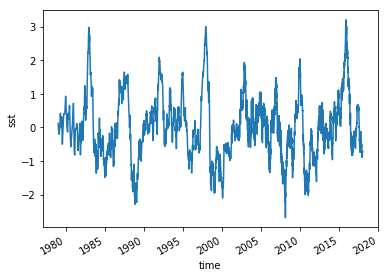

In [14]:
## Calculate SST daily anomalies and plot
SST_anomalies = NINO34.groupby('time.dayofyear') - annual_cycle
SST_anomalies.sst.plot()

4.	Apply a moving average of length equal to 30 days to smooth the daily SST anomalies.

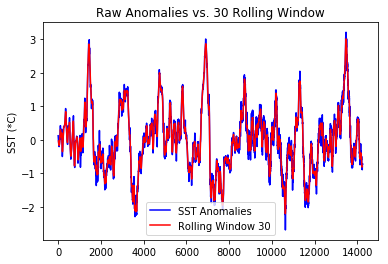

In [15]:
da = SST_anomalies.sst
yroll = da.rolling(time=30, center=True).mean()
## Plot to Compare
plt.plot(np.arange(SST_anomalies.sst.size), SST_anomalies.sst, 'b', label='SST Anomalies')
plt.plot(np.arange(yroll.size), yroll, 'r', label='Rolling Window 30')
plt.title('Raw Anomalies vs. 30 Rolling Window')
plt.ylabel('SST (*C)')
plt.legend()
plt.show()

5.	Repeat step 4 by applying a moving average of length equal to 150 days to smooth the daily SST anomalies.

In [16]:
da = SST_anomalies.sst
yroll = da.rolling(time=150, center=True).mean()

In [18]:
## Selecting the value every 5 months for plotting purposes
times_list_150 =  pd.date_range('1979-01-01-00', '2017-12-31-18', freq='150D', normalize=True)

# first_day_month_index = xr.cftime_range(start='1979', periods=468, freq='MS', calendar='standard')
SST_anomalies_month_start = yroll.sel(time=times_list_150)
SST_anomalies_month_start

<xarray.DataArray (time: 95)>
array([      nan,  0.039982,  0.484189,  0.208864, -0.105206, -0.128836,
       -0.200681, -0.136656,  0.401513,  1.273554,  1.977575,  0.116445,
       -0.888764, -0.39554 , -0.727619, -1.018453, -0.625951, -0.612028,
       -0.131724,  0.810479,  1.06133 ,  1.382332,  0.711731, -1.280453,
       -1.894337, -1.122316, -0.549497,  0.049665,  0.07585 ,  0.314079,
        0.379116,  0.778008,  1.637763,  0.183591,  0.031472,  0.631181,
        0.168268,  0.029123,  0.30893 ,  1.004721, -0.026619, -0.858288,
       -0.563907, -0.368012, -0.407314,  1.272593,  2.507284,  0.648614,
       -1.41214 , -1.385456, -1.065419, -1.535089, -0.749879, -0.663765,
       -0.513466, -0.090735, -0.134884,  0.472212,  1.310897,  0.246381,
        0.068332,  0.107809,  0.298183,  0.686584,  0.260348, -0.078083,
       -0.682838,  0.18883 ,  0.838063, -0.15724 , -1.199297, -1.480471,
       -0.317467, -0.709163,  0.140324,  1.071374,  0.706768, -1.372644,
       -1.564812, -0.

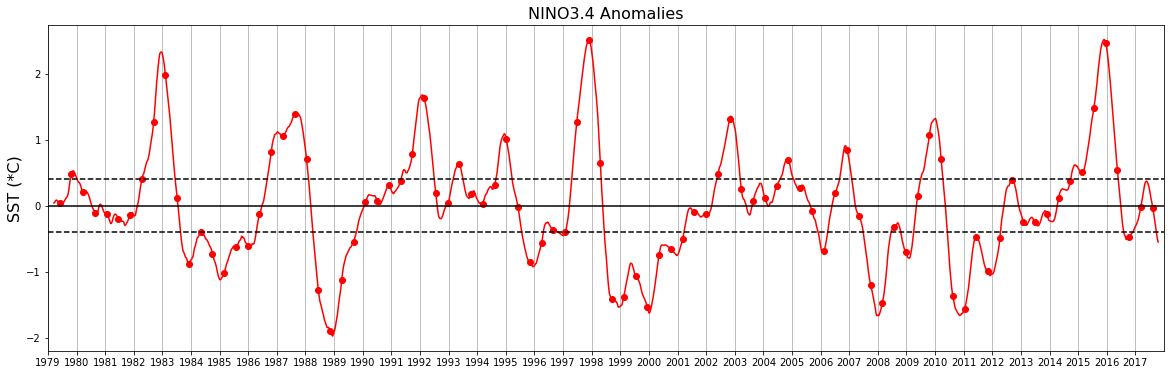

In [19]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.plot_date(SST_anomalies.time, yroll, 'r', label='Rolling Window 150')
ax.plot_date(SST_anomalies_month_start.time, SST_anomalies_month_start, 'ro')
ax.axhline(0.4, 0,1, color='k', linestyle='--')
ax.axhline(0.0, 0,1, color='k')
ax.axhline(-0.4, 0,1, color='k', linestyle='--')
plt.ylabel('SST (*C)', fontsize=16)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
# ax.xaxis.set_minor_locator(months)
ax.set_xlim('1979-01-01', '2017-12-31')
ax.xaxis.grid(True)
plt.title('NINO3.4 Anomalies', fontsize=16)
plt.show()
# ax.legend()
# fig.savefig('./results/fig2.png', dpi = 300)

6.	Based on the definition discussed in Trenberth 1997, identify El Niño years.

Although there have been many different ENSO indices with SST thresholds from 0.3\*C to 0.5\*C, Trenberth (1997) suggests that an El Nino can be said to occur if 5-month running means of sea surface temperature (SST) anomalies in the Nino 3.4 region (5°N-5°S, 120°-170°W) exceed 0.4°C for 6 months or more. According to the plot above and the definition discussed in Trenberth (1997), El Niño years are as follows: 1982-83, 1986-87, 1991-92, 1997-98, 2002-03, 2009-10, 2015-16. 

